In [5]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import grocerypathsim.parse_legend as lparse
from grocerypathsim.shopping_lists import ShoppingListGen
from grocerypathsim.parse_storelayout import StoreLayout
from grocerypathsim.path_generator import PathGenerator
from grocerypathsim.sim import *
from scipy import stats

In [6]:
image_data_dir = "sampledata"
grocery_data_dir = # your path here

In [7]:
# read legend image
legend_fp = os.path.join(image_data_dir, "SampleLegend.png")
legend = cv2.imread(legend_fp)

## Parse Legend

In [11]:
# get departments and manually repair
dpts = lparse.get_department_labels(legend)
print(dpts)
# repair departments
dpts = ['produce', 'grocery', 'meatdairy', 'household', 'frozen', 'checkout']

['j produce', 'grocery', 'meatdairy', 'household', 'wi frozen', 'i checkout']


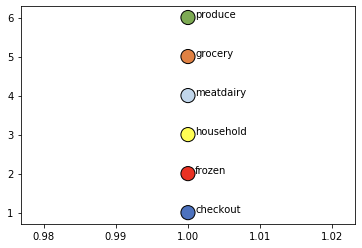

In [12]:
# get dataframe of colors, plot to inspect and verify
df = lparse.create_colormap_df(legend, dpts)
lparse.plot_colormap(df)

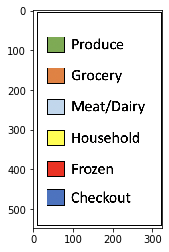

In [13]:
# confirm that this looks close to the original legend image
plt.imshow(cv2.cvtColor(legend, cv2.COLOR_BGR2RGB))

In [14]:
# Optionally save out the legend for future use
#df.to_csv("../legend_colormap.csv", index=False)

Looks good, let's keep going

# Parse Store Layout(s)

Here we'll parse 3 proposed store layouts to be compared. They all have the same legend, so the dataframe from the legend parsing step is passed into all 3.

In [16]:
layoutfp1 = os.path.join(image_data_dir, 'floorplan1.png')
layoutfp2 = os.path.join(image_data_dir, 'floorplan2.png')
layoutfp3 = os.path.join(image_data_dir, 'floorplan3.png')

In [17]:
slayout1 = StoreLayout(layoutfp1, df)
slayout2 = StoreLayout(layoutfp2, df)
slayout3 = StoreLayout(layoutfp3, df)

# Create Shopping Lists

Create a generator object which produces realistic shopping lists for each customer, remapped to the departments from the proposed store layout legend.

In [24]:
# this is the departments from our legend by name and index
df['Department']

0      produce
1      grocery
2    meatdairy
3    household
4       frozen
5     checkout
Name: Department, dtype: object

**This is how the mapping is created for this specific legend and the Instacart Dataset**  
0 frozen --> 4 frozen    
1 other --> 6 None  
2 bakery --> 1 grocery  
3 produce --> 0 produce  
4 alcohol --> 6 None  
...  

  The mapping is stored as the indices of the right side. For example, [4, 6, 1, 0, 6, ...]  

  
  Any items mapped to category 6, "None", will be removed from the list. It denotes that the product isn't available in the store.


In [25]:
# substitute mapping to match dataset and legend
DPT_MAP = [4, 6, 1, 0, 6, 1, 1, 3, 1, 1, 3, 2, 1, 1, 1, 2, 3, 3, 1, 2, 6]
DPTS = list(df['Department'])

In [26]:
slg = ShoppingListGen(grocery_data_dir)

# Path Generators

In [27]:
pathgen1 = PathGenerator(slayout1)
pathgen2 = PathGenerator(slayout2)
pathgen3 = PathGenerator(slayout3)

# Generate a Number of Customers

Simulate results for a specific number of customers, where each generated customer gets items from each of the layouts represented in the input path generators. 
Using the A* algorithm for path generation will result in a significant slowdown, but more accurate results. 

In [40]:
path_generators = [pathgen1, pathgen2, pathgen3] # path generators for layouts to compare
shopping_list_generator = slg # shopping list generator
customers = 10000 # number of customers
astarpathfinding = False # whether to use A* algorithm for path finding in addition to Euclidean distance
display_iteration_times = False # whether to print the time passed for each iteration

In [41]:
sim_results = simulate(path_generators, shopping_list_generator, customers, astarpathfinding, display_iteration_times)

In [42]:
sim_results.head()

,1euc,2euc,3euc,time (seconds),list_length
0,1826.919641,1658.648129,1798.864470,0,14
1,1717.043483,1865.890118,1156.809705,0,14
2,2509.942473,2079.711921,2377.245787,0,28
3,1603.803740,2094.054705,1158.481874,0,12
4,1401.968644,839.372715,1016.243100,0,8


Layout numbers are represented by the order their path generators were put in. "euc" denotes Euclidean distance between points on the path. "ast" denotes A* path between points, which involves avoiding aisles. These columns exist only if astarpathfindng is True. Time is the computation time in seconds, which is typically only greater than 0 when A* is used. "list_length" is the number of items on the customer's grocery list.

# Results - Compare Path Lengths

Create paired confidence intervals between each of the layouts. Input the results of the simulation (the dataframe output) and the columns to compare, which should be the different layout path lengths for the same distance metric.

In [45]:
alpha=.05 # (1-alpha)% Confidence interval
comp12 = compute_paired_CI(sim_results, '1euc', '2euc', alpha)
comp13 = compute_paired_CI(sim_results, '1euc', '3euc', alpha)
comp23 = compute_paired_CI(sim_results, '2euc', '3euc', alpha)

Now plot the results

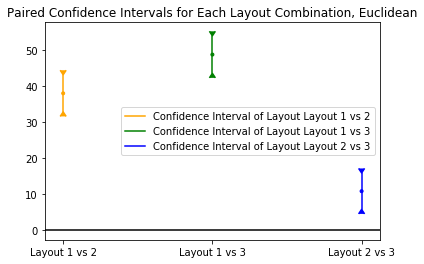

In [48]:
cis = [comp12, comp13, comp23] # Confidence intervals to plot
ci_names = ["Layout 1 vs 2", "Layout 1 vs 3", "Layout 2 vs 3"] # Names of those CIs for the legend and axis labels
distance_metric_used = "Euclidean" # Name of the distance metric this represents for the plot title
plot_paired_CIs(cis, ci_names, distance_metric_used)

From this we can say with 95% confidence that the mean path length using the Euclidean distance to measure paths for Layout 1 is higher than Layout 2, for Layout 1 is higher than for Layout 3, and for Layout 2 is higher than for Layout 3. We conclude that using the Euclidean distance Layout 1 generates the longest average customer path. Importantly, the path distance using A* paths is not always the same as the Eucidean distance, and the A* path is likely to be more accurate. However, it takes a very long time to run.

In [50]:
#Similar code for A* path length, if it's computed
"""
comp12 = compute_paired_CI(res_df, '1ast', '2ast')
comp13 = compute_paired_CI(res_df, '1ast', '3ast')
comp23 = compute_paired_CI(res_df, '2ast', '3ast')
plot_paired_CIs([comp12, comp13, comp23], ["Layout 1 vs 2", "Layout 1 vs 3", "Layout 2 vs 3"], "A*")
"""

'\ncomp12 = compute_paired_CI(res_df, \'1ast\', \'2ast\')\ncomp13 = compute_paired_CI(res_df, \'1ast\', \'3ast\')\ncomp23 = compute_paired_CI(res_df, \'2ast\', \'3ast\')\nplot_paired_CIs([comp12, comp13, comp23], ["Layout 1 vs 2", "Layout 1 vs 3", "Layout 2 vs 3"], "A*")\n'

# Look at an Example

In [63]:
curr_grocery_list = next(slg)

In [64]:
curr_grocery_list

,order_id,product_id,product_name,mapped_dpt,mapped_dpt_name
712,1834363,10246,Organic Celery Hearts,0,produce
50473,1834363,30391,Organic Cucumber,0,produce
65851,1834363,39275,Organic Blueberries,0,produce
124953,1834363,11182,Baby Spinach,0,produce
300628,1834363,42701,Organic Sour Cream,2,meatdairy
540591,1834363,9839,Organic Broccoli,0,produce
586568,1834363,33705,New York Cheddar Potato Chips,1,grocery
856943,1834363,39001,Organic Avocados Hass Variety,0,produce
1141450,1834363,36149,Beast Burger,4,frozen
1146621,1834363,22525,Dried Strawberries,1,grocery


In [65]:
# choose where each of these items lie within their departments
pix_coords = pathgen1.generate_pixel_coordinates(curr_grocery_list)
# create a visitation order probabilistically
ordered, euc_dist = pathgen1.order_coords(pix_coords)
# find the A* path 
full_path, astar_dist = pathgen1.calc_path_astar(ordered)

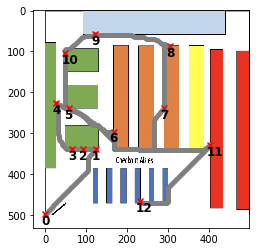

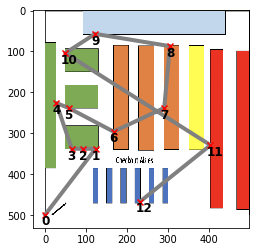

In [66]:
pathgen1.plot_astar_path(full_path, ordered)
pathgen1.plot_euclidean_path(ordered)